In [57]:
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline

from keras.preprocessing.image import ImageDataGenerator
from keras.applications.vgg16 import VGG16
from keras.layers import Dense, Flatten, Dropout
from keras.models import Model, load_model
from keras.optimizers import Adam
from livelossplot.inputs.keras import PlotLossesCallback
from keras.callbacks import ModelCheckpoint, EarlyStopping
from sklearn.metrics import confusion_matrix, classification_report

In [58]:
# Paths and parameters
best_cars_model_path = 'best_cars_model.h5'
train_cars_dataset_path = 'data/cars_train/train'
test_cars_dataset_path = 'data/cars_train/test'
mean = np.array([0.4708, 0.4602, 0.4550])
std = np.array([0.2593, 0.2584, 0.2634])
BATCH_SIZE = 64

In [59]:
# Data augmentation and preprocessing
train_datagen = ImageDataGenerator(
    rescale=1./255,
    featurewise_center=True,
    featurewise_std_normalization=True,
    horizontal_flip=True,
    rotation_range=10,
    shear_range=0.2,
    zoom_range=0.2,
    brightness_range=[0.5, 1.5]
)
train_datagen.mean = mean
train_datagen.std = std

train_generator = train_datagen.flow_from_directory(
    train_cars_dataset_path,
    target_size=(224, 224),
    batch_size=BATCH_SIZE,
    class_mode='categorical'
)

test_datagen = ImageDataGenerator(
    rescale=1./255,
    featurewise_center=True,
    featurewise_std_normalization=True
)
test_datagen.mean = mean
test_datagen.std = std

test_generator = test_datagen.flow_from_directory(
    test_cars_dataset_path,
    target_size=(224, 224),
    batch_size=BATCH_SIZE,
    class_mode='categorical',
    shuffle=False
)

Found 6442 images belonging to 196 classes.
Found 1702 images belonging to 196 classes.


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


Labels: [ 28 115  23  90 108 110 130  76 163  79  62 103   1  35  69  82  15 133
  57 110 189  78  60 193   6 176 101  73 194  36  85 100 122 183  55 105
 143  87  42 137 190 144   9 121 126 193 180  18 124 178 110 159  82  80
 122  50  99  49 124  78 120  80 101 154]


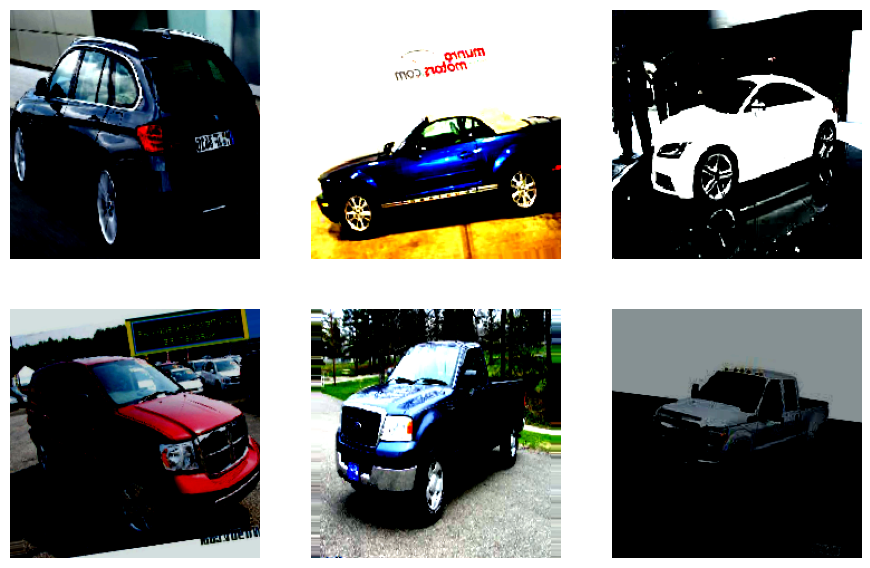

In [60]:
# Display some images
def show_transformed_images(generator, num_images=6):
    images, labels = next(generator)
    print(f"Labels: {np.argmax(labels, axis=1)}")
    plt.figure(figsize=(11,11))
    for i in range(num_images):
        plt.subplot(3, 3, i+1)
        plt.imshow(images[i])
        plt.axis('off')
    plt.show()

show_transformed_images(train_generator)

In [61]:
def create_model(input_shape, n_classes, optimizer='adam', fine_tune=0):
  base_model = VGG16(weights='imagenet', include_top=False, input_shape=input_shape)
  
  if fine_tune > 0:
    for layer in base_model.layers[:-fine_tune]:
      layer.trainable = False
  else:
    for layer in base_model.layers:
      layer.trainable = False

  top_model = base_model.output
  top_model = Flatten()(top_model)
  top_model = Dense(4096, activation='relu')(top_model)
  top_model = Dense(1072, activation='relu')(top_model)
  top_model = Dropout(0.2)(top_model)
  output_layer = Dense(n_classes, activation='softmax')(top_model)
  
  model = Model(inputs=base_model.input, outputs=output_layer)

  model.compile(optimizer=optimizer, loss='categorical_crossentropy', metrics=['accuracy'])
  
  return model

In [62]:
# Defining model
num_classes = len(train_generator.class_indices)

model = create_model(input_shape=(224, 224, 3), n_classes=num_classes, optimizer=Adam(learning_rate=0.001))

model.summary()

Model: "model_3"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_7 (InputLayer)        [(None, 224, 224, 3)]     0         
                                                                 
 block1_conv1 (Conv2D)       (None, 224, 224, 64)      1792      
                                                                 
 block1_conv2 (Conv2D)       (None, 224, 224, 64)      36928     
                                                                 
 block1_pool (MaxPooling2D)  (None, 112, 112, 64)      0         
                                                                 
 block2_conv1 (Conv2D)       (None, 112, 112, 128)     73856     
                                                                 
 block2_conv2 (Conv2D)       (None, 112, 112, 128)     147584    
                                                                 
 block2_pool (MaxPooling2D)  (None, 56, 56, 128)       0   

In [63]:
# Callbacks
plot_loss = PlotLossesCallback()
checkpoint = ModelCheckpoint(best_cars_model_path, save_best_only=True, verbose=1)
early_stop = EarlyStopping(monitor='val_loss', patience=10, restore_best_weights=True, mode='min')

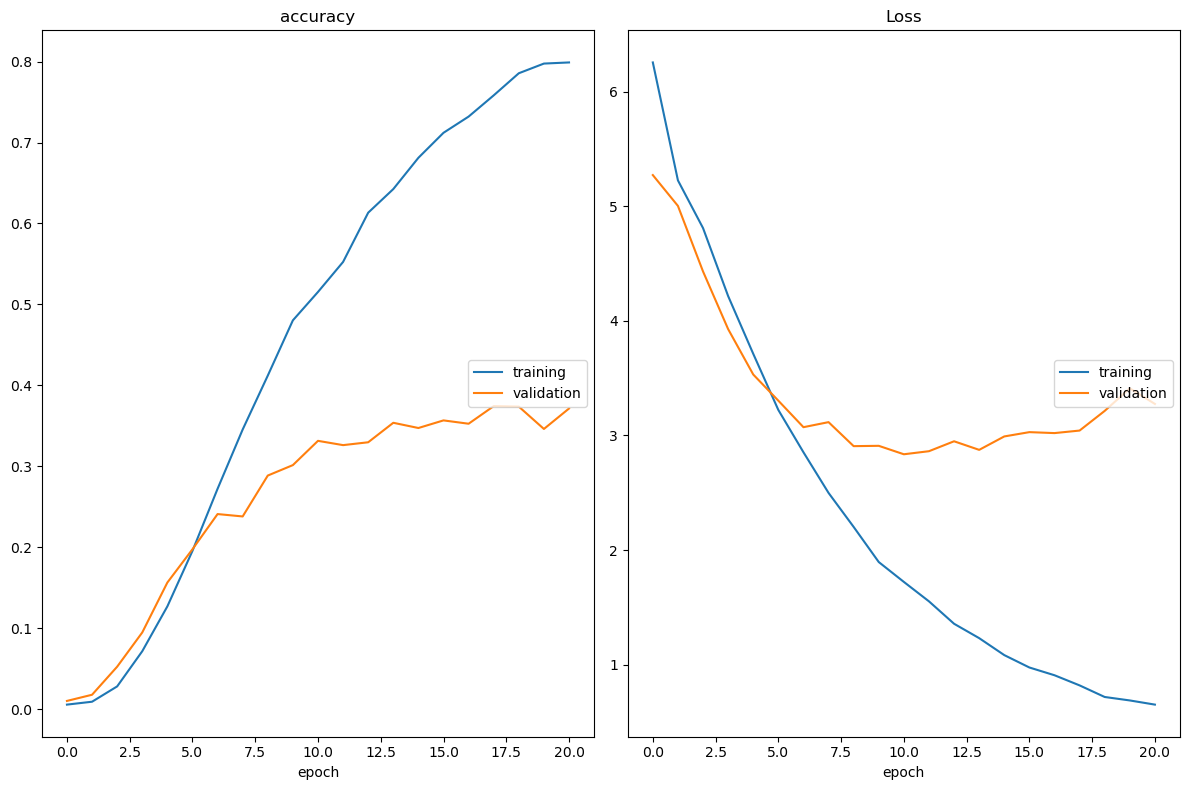

accuracy
	training         	 (min:    0.005, max:    0.799, cur:    0.799)
	validation       	 (min:    0.010, max:    0.374, cur:    0.371)
Loss
	training         	 (min:    0.651, max:    6.254, cur:    0.651)
	validation       	 (min:    2.835, max:    5.271, cur:    3.275)
101/101 [==============================] - 551s 5s/step - loss: 0.6510 - accuracy: 0.7990 - val_loss: 3.2745 - val_accuracy: 0.3713


In [64]:
# Train the model
history = model.fit(
  train_generator,
  batch_size=BATCH_SIZE,
  epochs=100,
  validation_data=test_generator,
  callbacks=[checkpoint, early_stop, plot_loss],
  verbose=1
)

In [65]:
# Load the best model
best_model = load_model(best_cars_model_path)

# Evaluation
train_loss, train_acc = best_model.evaluate(train_generator, verbose=0)
print(f'Train loss: {train_loss}')
print(f'Train accuracy: {train_acc}')

test_loss, train_acc = best_model.evaluate(test_generator, verbose=0)
print(f'Test loss: {test_loss}')
print(f'Test accuracy: {train_acc}')

Train loss: 1.1782487630844116
Train accuracy: 0.6740142703056335
Test loss: 2.8353395462036133
Test accuracy: 0.331374853849411


In [66]:
# Prediction and metrics
predictions = best_model.predict(test_generator)
predicted_classes = np.argmax(predictions, axis=1)
true_classes = test_generator.classes

27/27 [==============================] - 103s 4s/step


In [67]:
confusion_mtx = confusion_matrix(true_classes, predicted_classes)
confusion_mtx

array([[5, 0, 0, ..., 0, 0, 0],
       [0, 3, 0, ..., 0, 0, 0],
       [0, 0, 0, ..., 0, 0, 0],
       ...,
       [0, 0, 0, ..., 1, 0, 0],
       [0, 0, 0, ..., 0, 1, 0],
       [0, 0, 0, ..., 0, 0, 5]], dtype=int64)

In [68]:
print('Classification Report')
print(classification_report(true_classes, predicted_classes))

Classification Report
              precision    recall  f1-score   support

           0       0.71      0.56      0.63         9
           1       0.50      0.33      0.40         9
           2       0.00      0.00      0.00         7
           3       0.21      0.33      0.26         9
           4       0.20      0.11      0.14         9
           5       0.38      0.33      0.35         9
           6       0.14      0.12      0.13         8
           7       0.18      0.33      0.23         9
           8       0.00      0.00      0.00         9
           9       0.25      0.14      0.18         7
          10       0.33      0.25      0.29         8
          11       0.36      0.44      0.40         9
          12       0.50      0.11      0.18         9
          13       0.50      0.11      0.18         9
          14       0.50      0.11      0.18         9
          15       0.21      0.38      0.27         8
          16       0.00      0.00      0.00         9
     

c:\Users\rauls\anaconda3\envs\directML\lib\site-packages\sklearn\metrics\_classification.py:1471: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
c:\Users\rauls\anaconda3\envs\directML\lib\site-packages\sklearn\metrics\_classification.py:1471: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
c:\Users\rauls\anaconda3\envs\directML\lib\site-packages\sklearn\metrics\_classification.py:1471: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
